# 5 Traits Localized Model
> In psychological trait theory, the Big Five personality traits, also known as the five-factor model (FFM) and the OCEAN model, is a suggested taxonomy, or grouping, for personality traits, developed from the 1980s onwards. When factor analysis (a statistical technique) is applied to personality survey data, some words used to describe aspects of personality are often applied to the same person. For example, someone described as conscientious is more likely to be described as "always prepared" rather than "messy". This theory is based therefore on semantic associations between words and not on neuropsychological experiments. This theory uses descriptors of common language and suggests five broad dimensions commonly used to describe the human personality and psyche.
The theory identifies five factors:
> - openness to experience (inventive/curious vs. consistent/cautious)
> - conscientiousness (efficient/organized vs. easy-going/careless)
> - extroversion (outgoing/energetic vs. solitary/reserved)
> - agreeableness (friendly/compassionate vs. challenging/detached)
> - neuroticism (sensitive/nervous vs. secure/confident)

[Big Five personality traits](https://en.wikipedia.org/wiki/Big_Five_personality_traits)

The questionare consists of 50 statements, on which person is asked to anwser (on 1 to 5 scale), how much ge agrees on the statement. The statements are divided into 5 groups assosited with the traits. On top of that, we have informations about the place, where survey took place. 


# Simple bayesian interpretation
![](images/5_traits_model_localized.svg)

In the Big 5 Peronality traits model, we assume that, that user personality can be described by 5 dimensional, orthogonal vector, where each dimension is orthogonal to each other (at least in respect to quiz questions). 

## Distributions
Each trait will be modeled as a Beta distribution, with \\(\alpha\\) and \\(\beta\\) conditioned on country. ie:
\begin{equation}
Openness \sim Beta(\alpha=\alpha_{openness}, \beta = \beta_{openness})
\end{equation}

At last, we assume that each statement agreement comes from a binomial dristribution, where n=4, and p=Trait, eg.

\begin{equation}
OPN_i^* \sim Binomial(n=4, p=Openness_c) + 1
\end{equation}

We do it for every question, for every sample. This way, we can interpret trait as measure of likelihood, that someone would agree with the statement (ie. we transform a 5-scale problem into binary problem, so that the trait can be interpreted as probability of someone agreeing with the question. The +1 comes from the fact, that opinions range from 1 - 5, rather that 0 - 4. The star in the notation means a standarized anwser. Some statements are reverse (ie. I don't like people in extraversion trait). By standarized statement we mean, that for such cases we flip the question into agreeing form (I like people) and change the anwser as following
\begin{equation}
OPN_i^* = 6 - OPN_i
\end{equation}

In [82]:
import torch
import pyro
import pyro.distributions as dist
from common import N_COUNTIRES, load_joint, empty_df, positive_correlation, QUESTIONS
from sklearn.preprocessing import OrdinalEncoder
import torch.distributions.constraints as const
import pyro.poutine as poutine
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display

## Model definition

In [254]:
class BigFiveModel:
    # Parameters of prior trait distributions
    ALPHA_PRIOR = 1.0
    BETA_PRIOR = 1.0
    
    def __init__(self):           
        initial_obs = {
            **{
                key: []
                for key in QUESTIONS.keys()
            },
            'country': []
        }

        self._observations = pd.DataFrame(initial_obs)
        self._mask = np.zeros((0, 51))
        
        self.fitted = False
        
        
    def _add_user(self, user: str):
        initial_obs = {
            **{
                key: 0
                for key in QUESTIONS.keys()
            },
            'country': 0
        }
        
        self._observations = pd.concat([
            self._observations, 
            pd.DataFrame(initial_obs, index=[user])
        ])
        self._mask = np.concatenate([
            self._mask,
            np.zeros((1, 51))
        ])
        
    
    def model(self, anwsers, countries, anwser_mask = None, country_mask = None):                 
        n_samples = anwsers.shape[-1]
        
        trait_alpha_priors = pyro.param('trait_alpha_priors', self.ALPHA_PRIOR * torch.ones(5, N_COUNTIRES), constraint=const.positive)
        trait_beta_priors = pyro.param('trait_beta_priors', self.BETA_PRIOR * torch.ones(5, N_COUNTIRES), constraint=const.positive)

        # Don't fit priors in inference stage
        if self.fitted:
            trait_alpha_priors = torch.tensor(self.prior_alphas)
            trait_beta_priors = torch.tensor(self.prior_betas)
        
        with pyro.plate("person", n_samples):
            country = countries
            if country_mask is not None:
                # Make prior a non-trainable uniform
                country = pyro.sample('country', dist.Categorical(torch.ones(N_COUNTIRES)).mask(country_mask))

                # Overwire countires that are observed
                country = countries * country_mask + (country * (1.0 - country_mask))
                            
            with pyro.plate('traits', 5):
                # Prior on traits will depend on country. This way we can use country to reinforce our predictions with better prior,
                # which is not biased by imbalanced country
                trait = pyro.sample('trait', dist.Beta(trait_alpha_priors[:, country.long()], trait_beta_priors[:, country.long()]))

                with pyro.plate("question", 10):
                    # assume uniform
                    distribution = dist.Binomial(4, trait)
                    if anwser_mask != None:
                        distribution = distribution.mask(anwser_mask)
                    
                    anwser = pyro.sample('anwser', distribution, obs=anwsers)

                    return anwser, trait
                               
    
    def train_guide(self, anwsers, countries, anwser_mask = None, country_mask = None):   
        n_samples = anwsers.shape[-1]
                
        # Not reeeeeeeeeaaaaaaaaally important, but hey - its a guide and posterior must fit :)
        trait_alphas = pyro.param('trait_alphas_train', self.ALPHA_PRIOR * torch.ones(5, n_samples), constraint=const.positive)
        trait_betas = pyro.param('trait_betas_train', self.BETA_PRIOR * torch.ones(5, n_samples), constraint=const.positive)
        
        with pyro.plate("person", n_samples):
            with pyro.plate('traits', 5):
                trait = pyro.sample('trait', dist.Beta(trait_alphas, trait_betas))
                    
                
    def infer_guide(self, anwsers, countries, anwser_mask = None, country_mask = None):  
        n_samples = anwsers.shape[-1]
        
        countries_probs = pyro.param('country_probs', torch.ones(N_COUNTIRES) / N_COUNTIRES, constraint = const.simplex)

        with pyro.plate("person", len(self._observations)):
            
            # Make prior a non-trainable uniform
            country = pyro.sample('country', dist.Categorical(logits=torch.log(countries_probs)).mask(country_mask))

            # Overwire countires that are observed
            country = countries * country_mask + (country * (1.0 - country_mask))
            
            with pyro.plate('traits', 5):
                trait_alphas = pyro.param('trait_alphas', self.ALPHA_PRIOR * torch.ones(5, N_COUNTIRES))
                trait_betas = pyro.param('trait_betas', self.BETA_PRIOR * torch.ones(5, N_COUNTIRES))

                trait = pyro.sample('trait', dist.Beta(trait_alphas[:, country.long()], trait_betas[:, country.long()]))   

                
    def observe(self, user: str, x: dict) -> None:        
        if user not in self._observations.index:
            self._add_user(user)
        
        for key, value in x.items():
            if key != 'country':
                # Filp value if it has negative corelation 
                if not positive_correlation(key):
                    value = 6 - value
                
                # We map values 1 - 5 into 0 - 4
                self._observations.loc[user, key] = np.clip(value - 1.0, 0, 4)
                self._mask[
                    self._observations.index.get_loc(user),
                    self._observations.columns.get_loc(key)
                ] = 1
            else:
                self._observations.loc[user, key] = value
                
    
    def fit_prior(self, data, num_steps = 5_000):            
        pyro.clear_param_store()
        pyro.enable_validation(True)
        svi = pyro.infer.SVI(model=self.model,
                             guide=self.train_guide,
                             optim=pyro.optim.Adam({"lr": 1e-2}),
                             loss=pyro.infer.Trace_ELBO())

        anwsers = torch.tensor(
            np.clip(data.drop('country', axis=1).values.reshape(-1, 5, 10).transpose([2, 1, 0]) - 1.0, 0.0, 4.0)
        )
        
        country = torch.tensor(
            data['country'].values.reshape(-1)
        )
                
        losses = []
        for t in tqdm(range(num_steps)):
            losses.append(svi.step(anwsers, country))
            
        # Freeze priors
        self.fitted = True
        self.prior_alphas = pyro.param('trait_alpha_priors').detach().numpy()
        self.prior_betas = pyro.param('trait_beta_priors').detach().numpy()
        

        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss")
                
                
    def infer(self, num_steps = 1_000, lr=5e-2):
        anwser_mask = torch.tensor(self._mask[:, :50].reshape(-1, 5, 10).transpose([2, 1, 0]))
        country_mask = torch.tensor(self._mask[:, 50].reshape(-1))
        
        anwsers = torch.tensor(
            self._observations.drop('country', axis=1).values.reshape(-1, 5, 10).transpose([2, 1, 0])
        )
        
        country = torch.tensor(
            self._observations['country'].values.reshape(-1)
        )
        
        pyro.clear_param_store()
        pyro.enable_validation(True)
        svi = pyro.infer.SVI(model=self.model,
                             guide=self.infer_guide,
                             optim=pyro.optim.Adam({"lr": lr}),
                             loss=pyro.infer.TraceGraph_ELBO())

        losses = []
        for t in tqdm(range(num_steps)):
            losses.append(svi.step(anwsers, country, anwser_mask, country_mask))

        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss")
        
    def sample(self, n_samples):
        return pyro.infer.Predictive(self.model, guide=self.traits_guide, num_samples=n_samples)()

In [265]:
data_1 = load_joint().dropna(axis=0)

In [266]:
contry_encoder = OrdinalEncoder()
data_1['country'] = contry_encoder.fit_transform(data_1['country'].values.reshape(-1, 1))

100%|██████████| 5000/5000 [01:04<00:00, 77.77it/s]


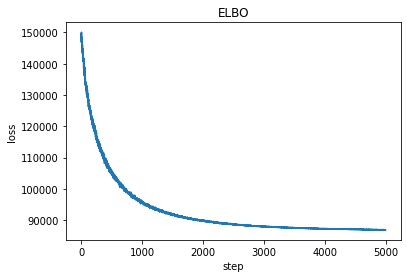

In [260]:
pyro.enable_validation(True)
model = BigFiveModel()
model.fit_prior(data_1)

## Perform inference of latents for dataset colected via survey
We (and our friends) did a Five Traits psychological test ourselves. Here we present infered distributions over latent variables for these anwsers to statements.

In [261]:
data = pd.read_csv("dataset/test_results.csv")

users = {}
for _, row in data.iterrows():
    name = row[1]
    users[name] = {
        key: row.values[2 + i]
        for i, key in enumerate(QUESTIONS.keys())
    }

In [264]:
for user, observations in users.items():
    model.observe(user, observations)
model.infer(2000)

 25%|██▌       | 507/2000 [00:02<00:07, 190.01it/s]


KeyboardInterrupt: 

In [263]:
pyro.param('country_probs').detach().numpy()

array([0.01736466, 0.01686192, 0.01662194, 0.01695778, 0.01602201,
       0.01797888, 0.0184483 , 0.01787258, 0.01829689, 0.01698616,
       0.01581833, 0.01735384, 0.01712149, 0.01812812, 0.01651926,
       0.01553261, 0.01612105, 0.01679028, 0.01689042, 0.01786496,
       0.01728389, 0.01719488, 0.01617063, 0.01508683, 0.01800878,
       0.01718871, 0.01760238, 0.01757941, 0.01769511, 0.01845183,
       0.01618276, 0.01623814, 0.0176825 , 0.01759106, 0.0182484 ,
       0.01706097, 0.01738195, 0.01854915, 0.0180332 , 0.01722343,
       0.01651153, 0.01742065, 0.01799831, 0.01719332, 0.0161303 ,
       0.01870553, 0.01716016, 0.0167863 , 0.01694542, 0.01734252,
       0.01713439, 0.01654059, 0.01709703, 0.01860971, 0.0158019 ,
       0.017745  , 0.01917801, 0.01769367], dtype=float32)

## Latent trait distribution
Display a trait probability distribution for each user in the database, based on their statements

In [ ]:
x = model.sample(1000)['trait'].detach().numpy().reshape(1000, 5, -1).transpose([2, 0, 1])

dfs = []
for i, user in enumerate(users.keys()):
    realistations = x[i, :, :]
    
    df = pd.DataFrame( {
        name: realistations[:, i]
        for i, name in enumerate(["extroversion", "neuroticism", "agreeableness", "conscientiousness", "openness"])
    })

    df = pd.melt(df, var_name="Trait")
    df['user'] = user[:5]
    
    dfs.append(df)

data_frame = pd.concat(dfs, ignore_index=True)

g = sns.FacetGrid(data=data_frame, row="user", col="Trait", hue="Trait")
g.map(sns.distplot, "value")